In [9]:
import numpy as np
import torch
from tqdm import tqdm
from Gridworld import * 
import matplotlib.pyplot as plt

In [599]:
game = Gridworld(size = 4,mode = 'static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [600]:
game.makeMove('l')
print(game.reward())
game.makeMove('l')   # reach -
print(game.reward())
game.makeMove('l')   # reach +
print(game.reward())

0
-1
1


In [601]:
model = torch.nn.Sequential(
    torch.nn.Linear(64,150),
    torch.nn.ReLU(),
    torch.nn.Linear(150,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,4)
)

loss_f = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [602]:
from tqdm import tqdm 
epsilon = 1.0
discount = 0.9
epochs = 1000
losses = []

for _ in tqdm(range(epochs)):
    game = Gridworld(size=4, mode='static')
    state = game.board.render_np().flatten().astype('float')
    state += np.random.rand(64) / 10. # noise
    state = torch.Tensor(state)
    gameover = 0
    while not gameover:
        qval = model(state)
        qval_ = qval.detach().numpy()
        if np.random.random() < epsilon:
            action = np.random.randint(0,4)
        else:
            action = np.argmax(qval_)

        game.makeMove('udlr'[action])
        reward = game.reward()

        new_state = game.board.render_np().flatten().astype('float')
        new_state += np.random.rand(64) / 10. 
        new_state = torch.Tensor(new_state)

        # use the prediction of the new_state to obtain the value of the new state
        # but do not change the grad of the model
        with torch.no_grad():
            new_value = torch.max( model(new_state) )
        
        if reward != 0: 
            gameover = 1
            reward = float(reward)
        else:
            reward = -0.01 + discount * new_value 

        reward = torch.Tensor([reward]).detach()
        predict = qval.squeeze()[action] 
        loss = loss_f(reward,predict)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = new_state
    
    if epsilon > 0.1:
        epsilon -= 1. / epochs

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\forever豪3\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [00:31<00:00, 31.35it/s]


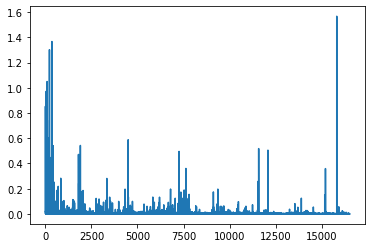

In [603]:
plt.plot(losses)

In [606]:
game = Gridworld(size=4, mode='static')
gameover = 0
print(game.display())
while not gameover:
    state = game.board.render_np().flatten().astype('float')
    state = torch.Tensor(state)
    qval = model(state).detach().numpy()
    action = np.argmax(qval)
    game.makeMove('udlr'[action])
    print('udlr'[action],end = ' ')
    if game.reward() != 0:
        gameover = 1

[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
d d l l l u u 